In [1]:
import numpy as np
import sys
sys.path.insert(0, '../')
import copy
import os
from rotm2euler import *
from test_utils import *
from experiment_utils import *

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import cm
from matplotlib import collections as mc
import pdb

## Input Data

In [2]:
### get pair id
pair_path = '/viscompfs/users/sawang/ScanNet/pair_list.txt'
f = open(pair_path)
lines = f.readlines()
lines[9995:10000]

['scene0001_01 1190-1200-1213 \n',
 'scene0001_01 1190-1201-1211 \n',
 'scene0001_01 1190-1202-1212 \n',
 'scene0001_01 1190-1203-1217 \n',
 'scene0001_01 1192-1204-1217 \n']

In [3]:
def input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W):
    data_dict = dict()
    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(tgt_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ori_H, ori_W, _ = image.shape
    image = cv2.resize(image, (320, 240))
    data_dict['tgt_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src0_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src0_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src1_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src1_RGB'] = image

    image = cv2.imread(os.path.join(gt_dir, scene, 'depth_interp', str(tgt_id) + ".png"), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (320, 240))
    data_dict['depth'] = image / 1000

    #image = cv2.imread(os.path.join('/viscompfs/users/sawang/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    #image = cv2.resize(image, (320, 240)) / 255
    #image = unplot_normal(image)
    #data_dict['tgt_norm'] = image
    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['tgt_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_1.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src0_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_3.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src1_norm'] = image

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_color.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K'] = mat
    print("intrinsic: \n", mat)

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_depth.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K_d'] = mat
    print("intrinsic (depth): \n", mat)

    pose_path = '/viscompfs/users/sawang/ScanNet/data_pose/' + scene + '.txt'
    f = open(pose_path)
    pose_all = f.readlines()

    for p in pose_all:
        char = p.split(" ")
        if char[0] == str(tgt_id) and char[1] == str(src1_id):
            data_dict['pose1'] = untransform(np.array([float(c.replace(",", "")) for c in char[2:]]))
            print("pose1: \n", data_dict['pose1'])
        elif char[0] == str(src0_id) and char[1] == str(tgt_id):
            tmp = np.array([float(c.replace(",", "")) for c in char[2:]])
            tmp = untransform(tmp)
            pose_inv = inversePose(tmp)
            data_dict['pose0'] = pose_inv
            print("pose0: \n", data_dict['pose0'])
    return data_dict

In [4]:
tgt_id, src0_id, src1_id = 1200, 1190, 1213
H, W = 240, 320
scene = 'scene0001_01'
dataset_dir = '/viscompfs/users/sawang/ScanNet/data/scans/'
gt_dir = '/viscompfs/users/sawang/ScanNet/data_gt/'

data = input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W)

intrinsic: 
 [[290.12925322   0.         160.59917355   0.        ]
 [  0.         288.93530568 119.44444444   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
intrinsic (depth): 
 [[143.27370372   0.          79.21487603   0.        ]
 [  0.         142.6841      59.13580247   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
pose0: 
 [[ 0.99720706 -0.01383514 -0.07339395  0.02787871]
 [ 0.00892915  0.99772935 -0.06675639 -0.09059185]
 [ 0.07415088  0.06591459  0.99506629  0.13103101]
 [ 0.          0.          0.          1.        ]]
pose1: 
 [[ 0.99900703 -0.03768448 -0.0237662   0.050552  ]
 [ 0.03849179  0.99866389  0.03447915  0.089673  ]
 [ 0.02243512 -0.03535972  0.99912279 -0.182378  ]
 [ 0.          0.          0.          1.        ]]


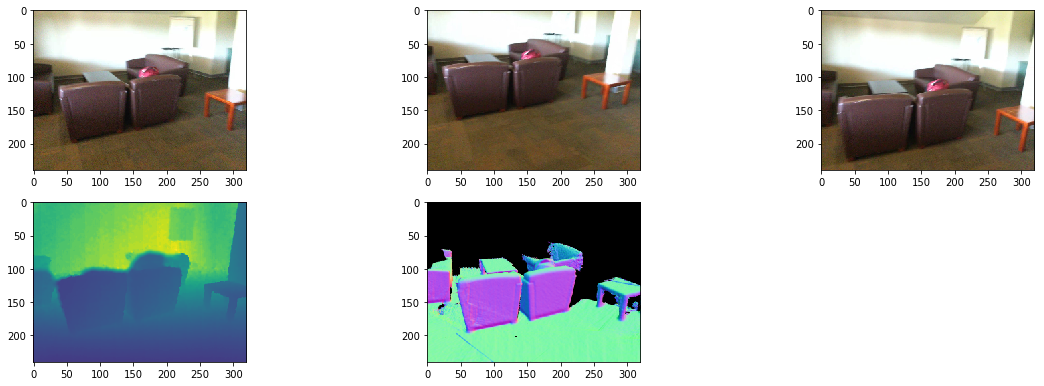

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(3, 3, 1)
ax.imshow(data['tgt_RGB'])
ax = fig.add_subplot(3, 3, 2)
ax.imshow(data['src0_RGB'])
ax = fig.add_subplot(3, 3, 3)
ax.imshow(data['src1_RGB'])
ax = fig.add_subplot(3, 3, 4)
ax.imshow(data['depth'])
ax = fig.add_subplot(3, 3, 5)
ax.imshow(plot_normal(data['tgt_norm']))
plt.show()

### Choose target location

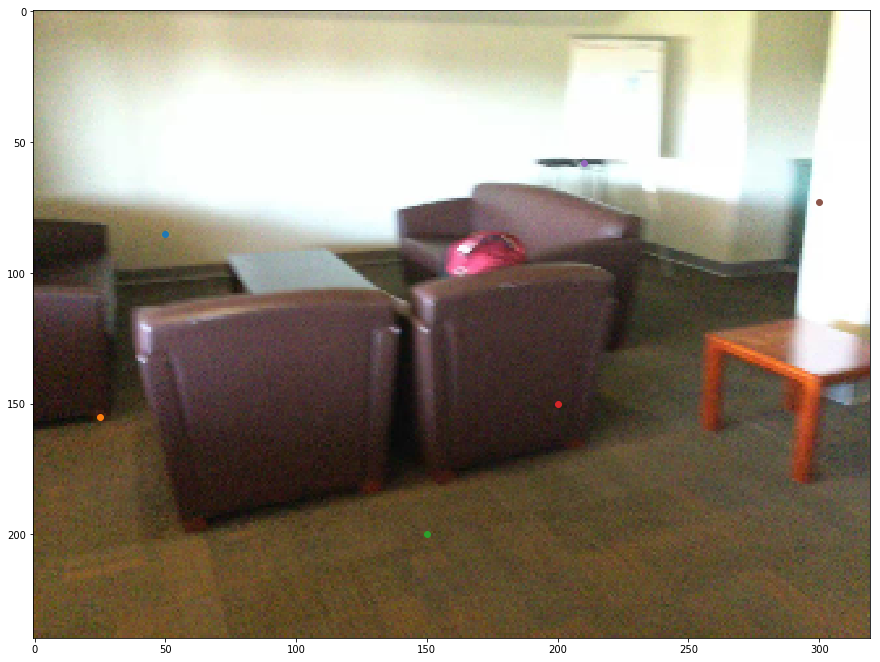

In [6]:
loc = np.array([[50, 25, 150, 200, 210, 300],
                [85, 155, 200,150,  58, 73]])


plt.figure(figsize=(15, 15))
plt.imshow(data['tgt_RGB'])
for [[x], [y]] in np.split(loc, loc.shape[1], axis=1):
    plt.scatter(x, y)
plt.show()

### Functions

In [71]:
def get_meshgrid(w, h, x_ctr, y_ctr):
    x_upper_left = x_ctr - w//2
    y_upper_left = y_ctr - h//2
    
    x = np.arange(0, w)
    y = np.arange(0 ,h)
    xv, yv = np.meshgrid(x, y)
    xv = xv.astype(np.float)
    yv = yv.astype(np.float)
    xv += x_upper_left
    yv += y_upper_left
    return xv, yv

def get_tgt_patch(pt, tgt, patch_size):
    x, y = pt[0, 0], pt[1, 0]
    ofs = (patch_size - 1) // 2
    return tgt[y-ofs:y+ofs+1, x-ofs:x+ofs+1]

def warp_patch(pt, depth, K, rel_pose, src, patch_size):
    ps_ctr = warp_location(pt, K, rel_pose, depth)
    xv, yv = get_meshgrid(patch_size, patch_size, ps_ctr[0, 0], ps_ctr[1, 0]) # x-coord, y-coord
    xv = xv.flatten()
    yv = yv.flatten()
    ps = np.vstack([xv, yv]) # [2, patch_size**2]
    
    patch_img = np.zeros([patch_size, patch_size, 3])
    for x in range(patch_size):
        for y in range(patch_size):
            i = y * patch_size + x
            patch_img[y, x] = bilinear_pt(ps[:, i, np.newaxis], src)
    return ps, patch_img

def plot_inv_curve(loc, loss_criterion,
                   tgt, src,
                   rel_pose, intrinsics, dmap):
    """Plot intensity difference versus inverse depth"""
    s = 3 # rectangle size
    psize = [3, 5, 7, 9, 11]
    colors = cm.rainbow(np.linspace(0, 1, loc.shape[1]))
    colors_p = cm.rainbow(np.linspace(0, 1, len(psize)))
    
    if type(tgt[0, 0, 0]) == np.uint8:
        tgt = tgt/255
    if type(src[0, 0, 0]) == np.uint8:
        src = src/255
    
    # prepare figure
    fig = plt.figure(figsize=(20, 10))
    ax_tgt = fig.add_subplot(131)
    ax_src = fig.add_subplot(132)
    ax_src_big = fig.add_subplot(133)
    ax_tgt.imshow(tgt)
    ax_src.imshow(src)
    ax_src_big.imshow(src)
    ax_tgt.set_title('Target')
    ax_src.set_title('Source')
    ax_src_big.set_title('Source Enlarged')
    ax_src.set_ylim(bottom=H, top=0)

    # warp provided coordinates
    inv_depth_values = np.arange(0.0001, 1.01, 0.0001)
    locations = np.split(loc, loc.shape[1], axis=1)

    # will contain tuple of ('pt', 'ps', 'It', 'Is', 'inv_depth', 'diff')
    result = defaultdict(list)
    r = namedtuple('r', 'pt ps It Is inv_depth diff')
    
    for i, (pt, c) in enumerate(zip(locations, colors)):
        print('{}/{} locations'.format(i+1, loc.shape[1]))
        for patch_size in psize:
            n_mid = (patch_size**2 - 1)//2
            tgt_patch = get_tgt_patch(pt, tgt, patch_size)
            for inv_d in inv_depth_values:
                # warp
                d = 1/inv_d
                src_coords, src_patch = warp_patch(pt, d, intrinsics, rel_pose, src, patch_size)
                ps = src_coords[:, n_mid, np.newaxis]
                diff = loss_criterion(tgt_patch, src_patch)
                tmp = r(pt=pt, ps=ps, It=tgt_patch, Is=src_patch, inv_depth=inv_d, diff=diff)
                result[(i, patch_size)].append(tmp)

    # plot RGB images for comparison
    print('Generating plots')
    for i, (pt, c) in enumerate(zip(locations, colors)):
        # plot rectangles on target image
        rect = patches.Rectangle((pt[0, 0]-s//2, pt[1, 0]-s//2), s, s,
                                 linewidth=1,edgecolor=c,facecolor='none')
        ax_tgt.add_patch(rect)

        # plot ground-truth correspondence on source image
        gt_corr = warp_location(pt, intrinsics, rel_pose, dmap[tuple(pt)[::-1]])
        rect2 = patches.Rectangle((gt_corr[0, 0]-s//2, gt_corr[1, 0]-s//2), s, s,
                                   linewidth=1,edgecolor=c,facecolor='none')
        rect2_ = patches.Rectangle((gt_corr[0, 0]-s//2, gt_corr[1, 0]-s//2), s, s,
                                   linewidth=1,edgecolor=c,facecolor='none')
        ax_src.add_patch(rect2)
        ax_src_big.add_patch(rect2_)
        ax_src_big.set_xlim([gt_corr[0, 0]-10, gt_corr[0, 0]+10])
        ax_src_big.set_ylim([gt_corr[1, 0]-10, gt_corr[1, 0]+10])

        # plot lowest photometric loss on source image
        for patch_size, c_p in zip(psize, colors_p):
            diffs = [x.diff for x in result[(i, patch_size)]]
            lowest_idx = np.argmin(diffs)
            lowest_ps = result[(i, patch_size)][lowest_idx].ps
            circle = patches.Circle((lowest_ps[0, 0], lowest_ps[1, 0]), radius=s//2,
                                     linewidth=1,edgecolor=c_p,facecolor='none')
            circle_ = patches.Circle((lowest_ps[0, 0], lowest_ps[1, 0]), radius=s//2,
                                     linewidth=1,edgecolor=c_p,facecolor='none')
            ax_src.add_patch(circle)
            ax_src_big.add_patch(circle_)
            #plt.text(lowest_ps[0, 0], lowest_ps[1, 0]-5, '{}'.format(patch_size))
            
    plt.show()

    # plot error curve
    for i in range(loc.shape[1]):
        gt_depth = dmap[tuple(locations[i])[::-1]]
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        ax.axvline(x=1/gt_depth, c='k', linewidth=3)
        print(locations[i].flatten(), 'ground truth depth', ':',gt_depth[0])
        
        p_min, err_min = -1, 1e6
        for patch_size, c in zip(psize, colors_p):
            diffs = [x.diff for x in result[(i, patch_size)]]
            lowest_idx = np.argmin(diffs)
            lowest_inv_depth = result[(i, patch_size)][lowest_idx].inv_depth
            ax.plot(inv_depth_values, diffs, c=c, label=patch_size)
            ax.axvline(lowest_inv_depth, c=c)
            print('p={} line depth w/ lowest error:{}'.format(patch_size, 1/lowest_inv_depth))
            
            # keep track of lowest error
            err = np.abs(gt_depth - 1/lowest_inv_depth)
            if err < err_min:
                p_min, err_min = patch_size, err
        print('The most accurate patch size: {}, abs error: {}'.format(p_min, err_min))
            
        ax.set_xlabel('Inverse Depth')
        ax.set_ylabel('Photometric Error')
        ax.legend()
        plt.show()

    plt.close('all')
    return result

1/1 locations
Generating plots


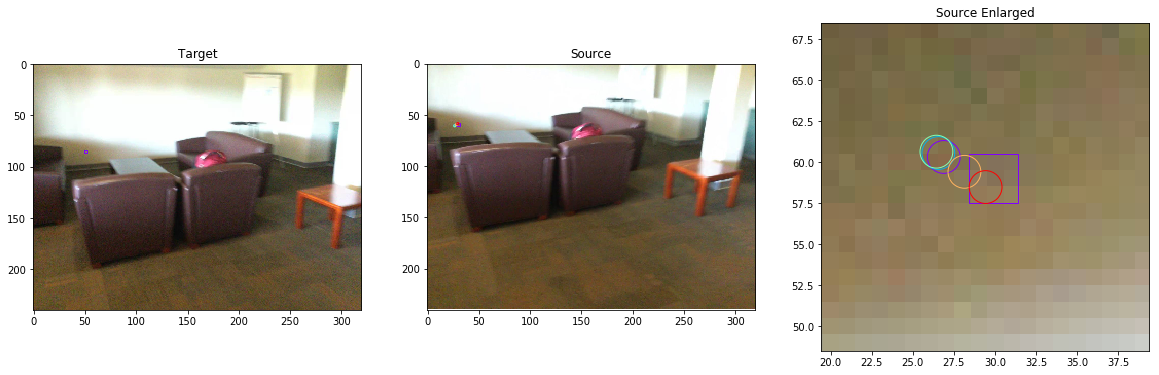

[50 85] ground truth depth : 4.774
p=3 line depth w/ lowest error:8.88888888888889
p=5 line depth w/ lowest error:10.01001001001001
p=7 line depth w/ lowest error:10.471204188481675
p=9 line depth w/ lowest error:6.222775357809582
p=11 line depth w/ lowest error:4.746084480303749
The most accurate patch size: 11, abs error: [0.02791552]


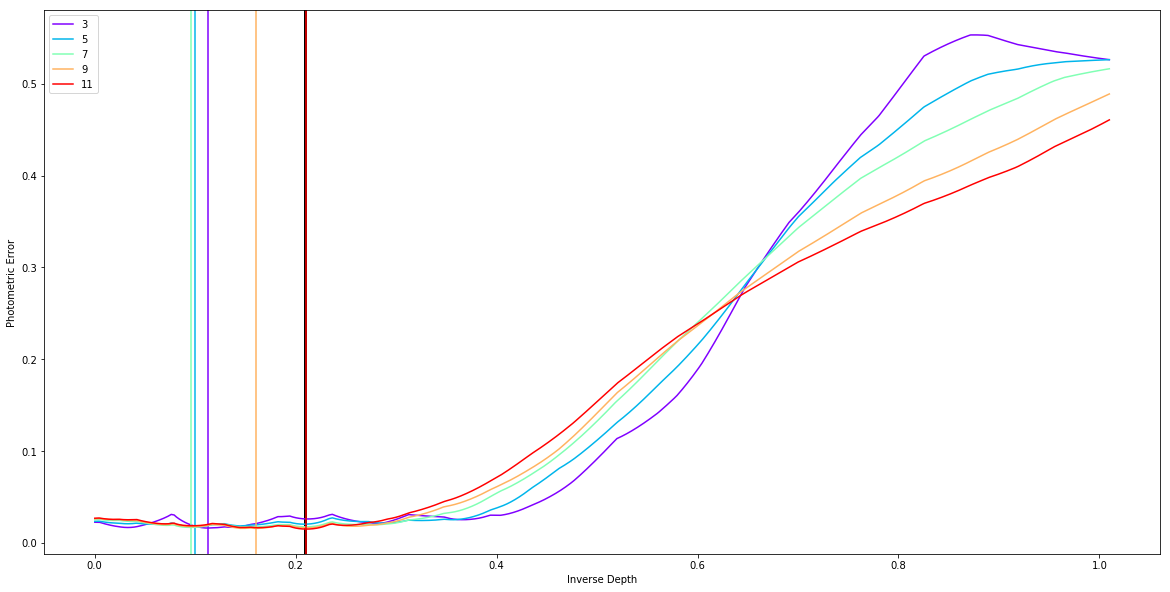

1/1 locations
Generating plots


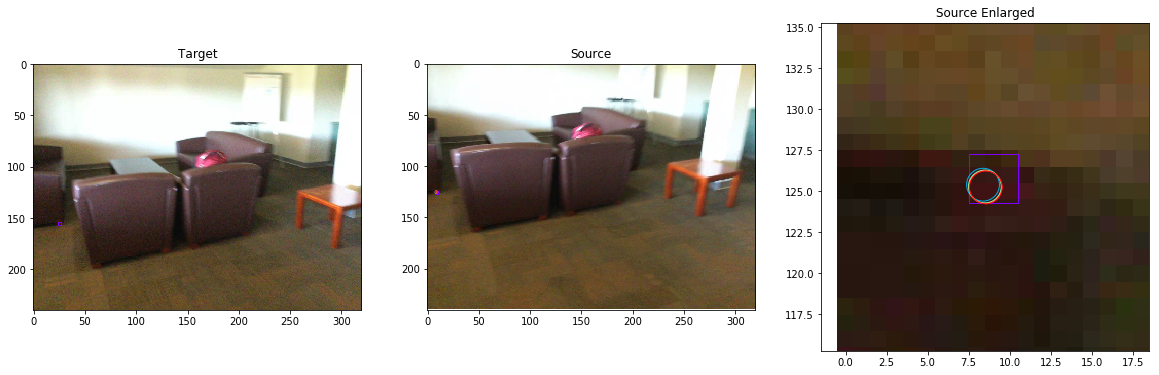

[ 25 155] ground truth depth : 2.889
p=3 line depth w/ lowest error:2.881844380403458
p=5 line depth w/ lowest error:2.9274004683840746
p=7 line depth w/ lowest error:2.8926815157651142
p=9 line depth w/ lowest error:2.882675122513693
p=11 line depth w/ lowest error:2.875215641173088
The most accurate patch size: 7, abs error: [0.00368152]


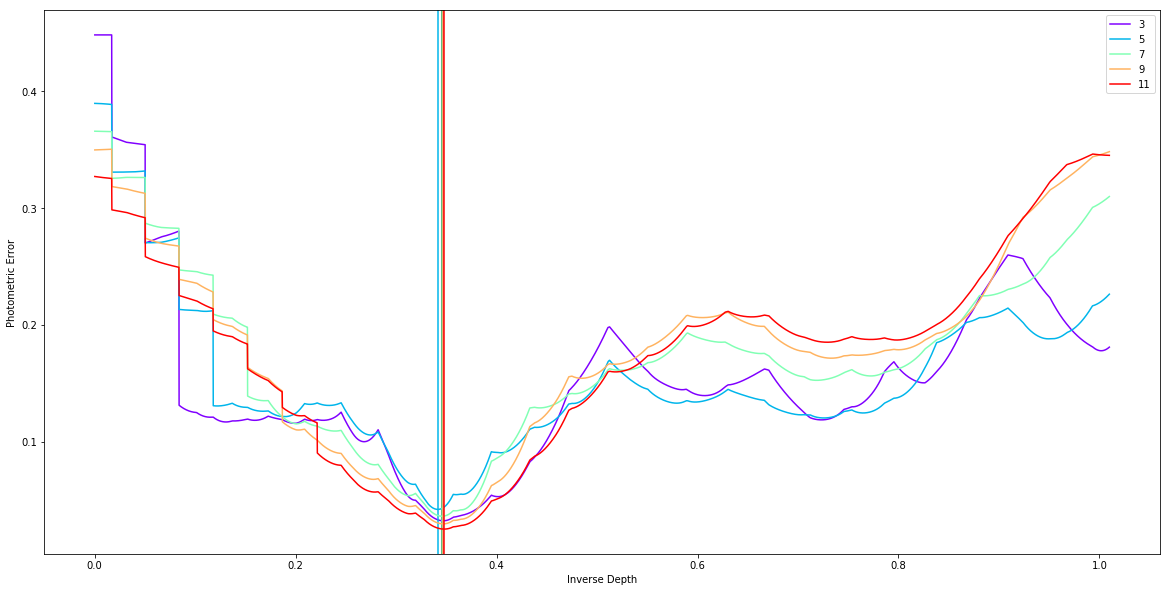

1/1 locations
Generating plots


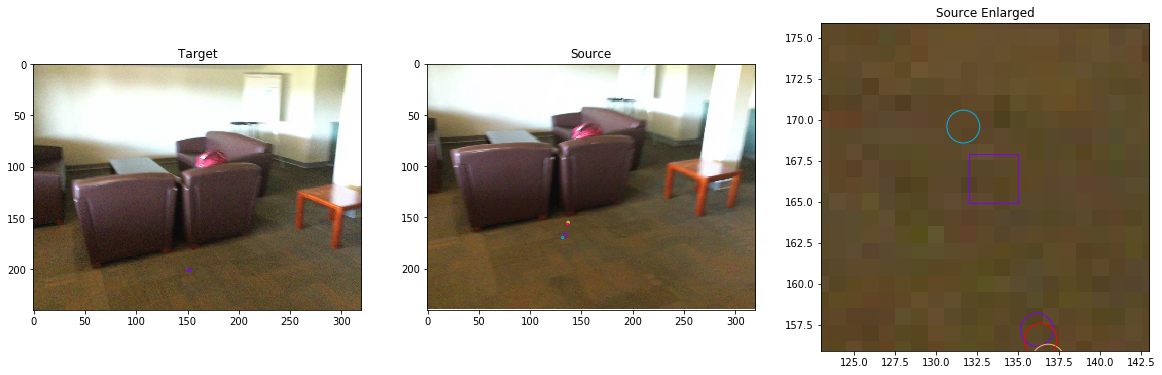

[150 200] ground truth depth : 2.301
p=3 line depth w/ lowest error:1.362954886193267
p=5 line depth w/ lowest error:3.17359568390987
p=7 line depth w/ lowest error:1.2155099064057373
p=9 line depth w/ lowest error:1.2482836100362003
p=11 line depth w/ lowest error:1.323276432446738
The most accurate patch size: 5, abs error: [0.87259568]


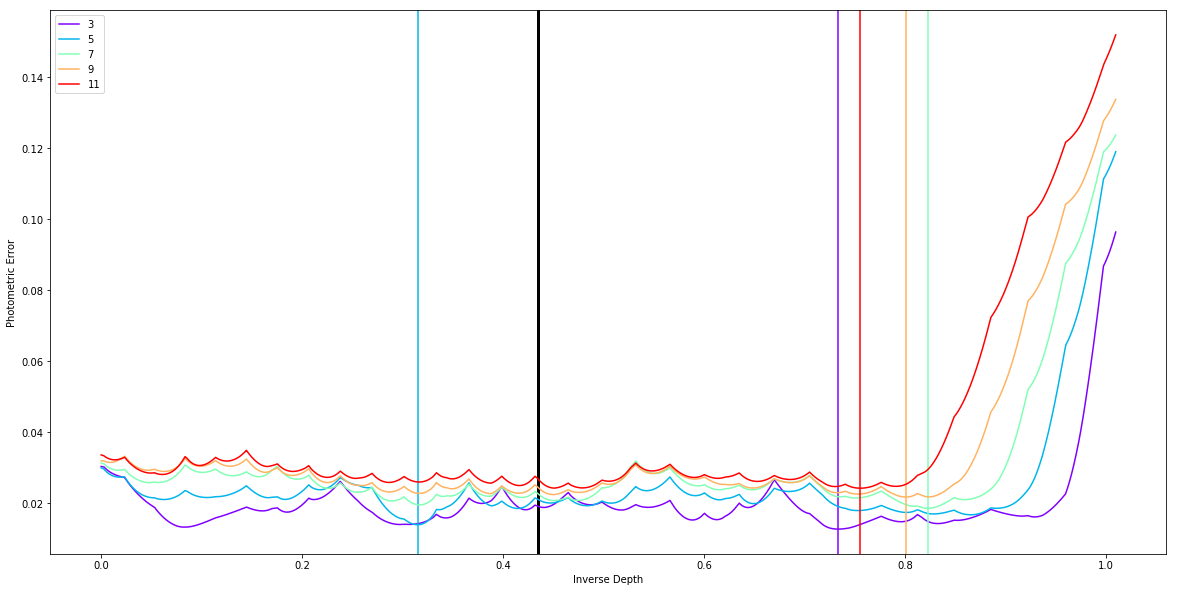

1/1 locations
Generating plots


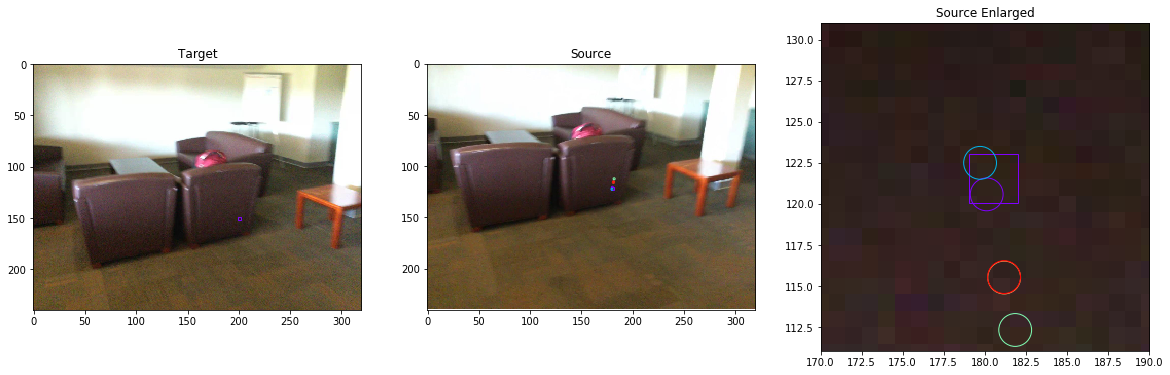

[200 150] ground truth depth : 2.658
p=3 line depth w/ lowest error:2.531004808909137
p=5 line depth w/ lowest error:3.1426775612822127
p=7 line depth w/ lowest error:1.3451708366962603
p=9 line depth w/ lowest error:1.6523463317911433
p=11 line depth w/ lowest error:1.6556291390728477
The most accurate patch size: 3, abs error: [0.12699519]


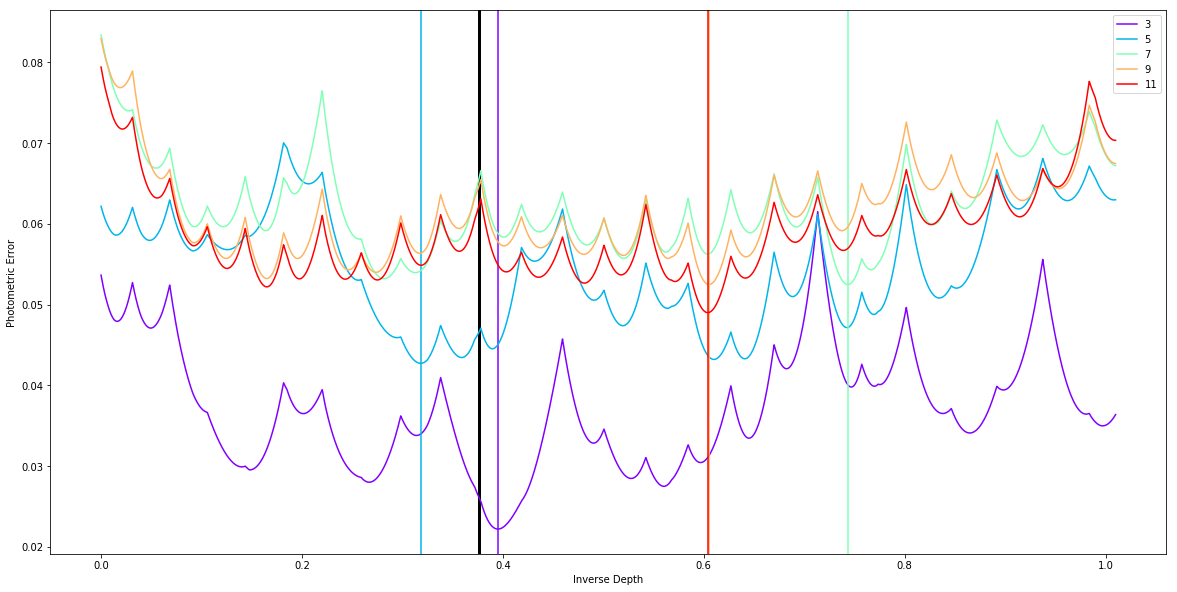

1/1 locations
Generating plots


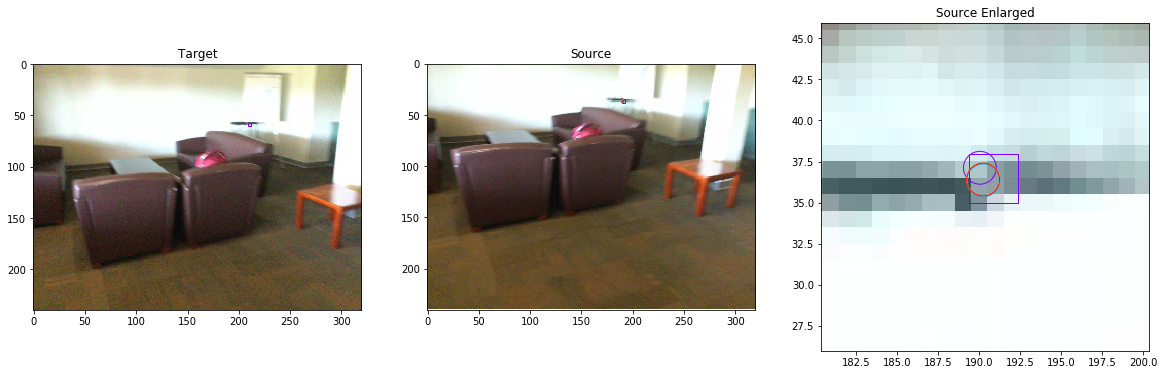

[210  58] ground truth depth : 5.449
p=3 line depth w/ lowest error:9.319664492078285
p=5 line depth w/ lowest error:6.3411540900443875
p=7 line depth w/ lowest error:6.49772579597141
p=9 line depth w/ lowest error:6.485084306095979
p=11 line depth w/ lowest error:6.472491909385114
The most accurate patch size: 5, abs error: [0.89215409]


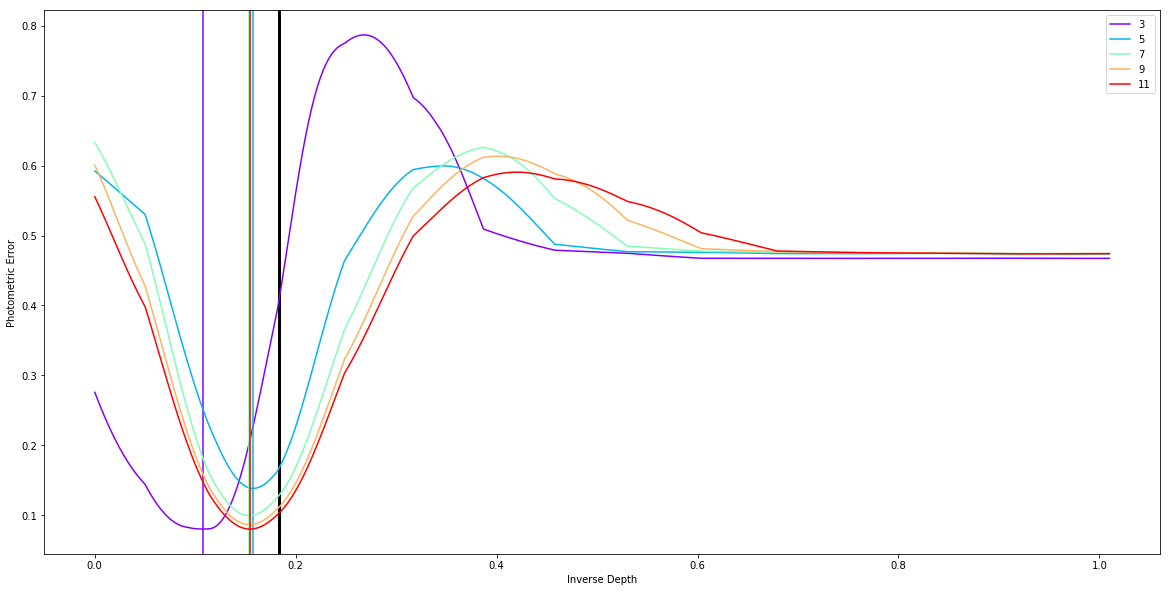

1/1 locations
Generating plots


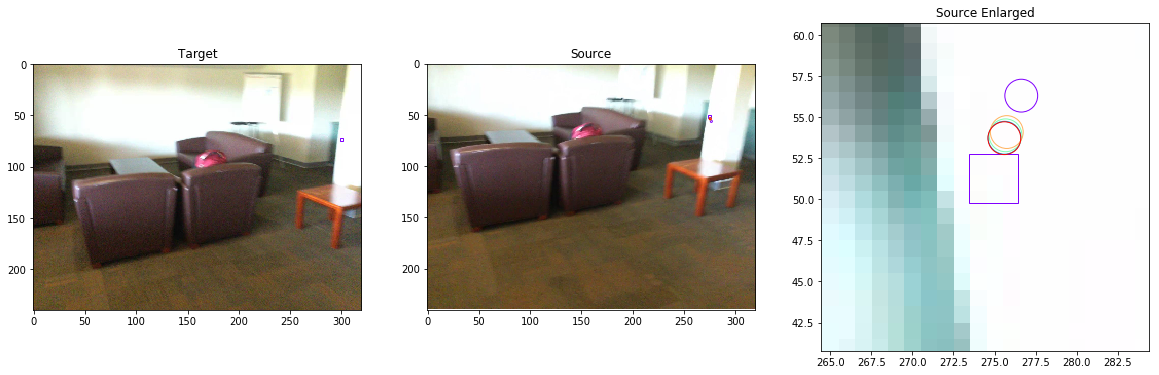

[300  73] ground truth depth : 3.035
p=3 line depth w/ lowest error:10000.0
p=5 line depth w/ lowest error:6.7114093959731544
p=7 line depth w/ lowest error:7.127583749109052
p=9 line depth w/ lowest error:7.776049766718508
p=11 line depth w/ lowest error:6.6401062416998675
The most accurate patch size: 11, abs error: [3.60510624]


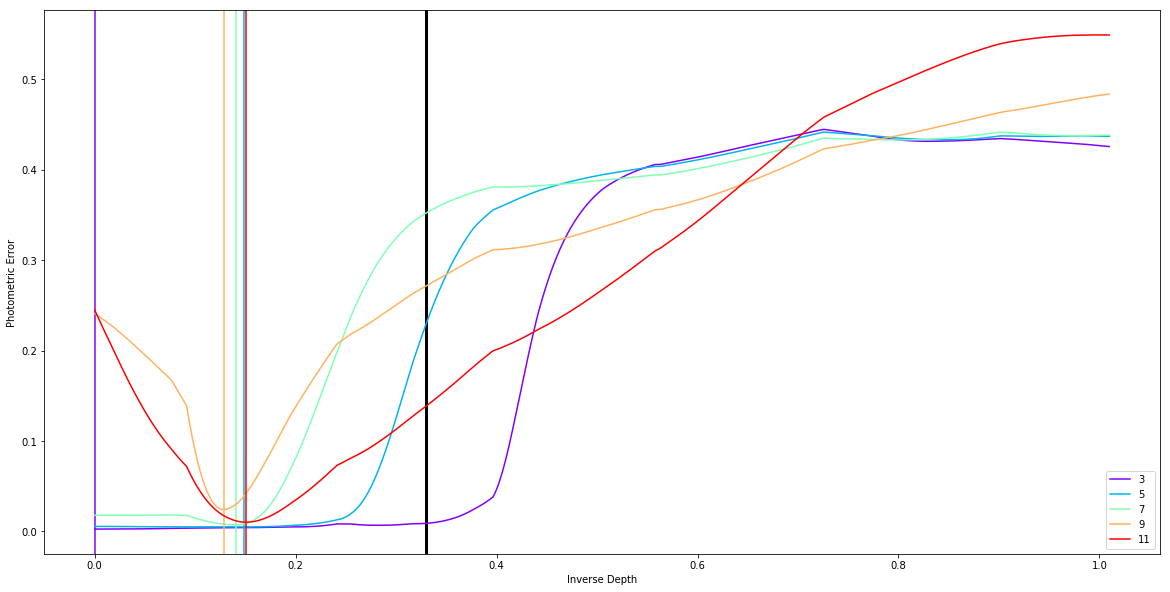

In [72]:
loss_criterion = loss_func()

result_dict = {}
for i in range(loc.shape[1]):
    result = plot_inv_curve(loc[:, i, np.newaxis],
                            loss_criterion,
                            data['tgt_RGB'],
                            data['src0_RGB'],
                            data['pose0'],
                            data['K'][:3, :3],
                            data['depth'])
    result_dict[i] = result